In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')

c:\Users\Kasandika Andariefli\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory Data Analysis

In [20]:
# Load the dataset with specified encoding
df = pd.read_csv('customer_booking.csv', encoding='latin1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [21]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (50000, 14)

Data types:
num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

Missing values:
num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64


In [22]:
print("\nBasic statistics:")
print(df.describe())


Basic statistics:
       num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

       wants_extra_baggage  wants_preferred_seat  wants_in_flight_meals  \
count         50000.000000          50000.000000           50000.000000   
mean              0.668780              0.296960               0.427140   
std               0.470657              0.456923               0.494668   
min               0.000000              0.000000           

## Univariate Analysis

In [23]:
# Check the target variable distribution
print("\nTarget variable distribution:")
print(df['booking_complete'].value_counts())
print(df['booking_complete'].value_counts(normalize=True))


Target variable distribution:
booking_complete
0    42522
1     7478
Name: count, dtype: int64
booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64


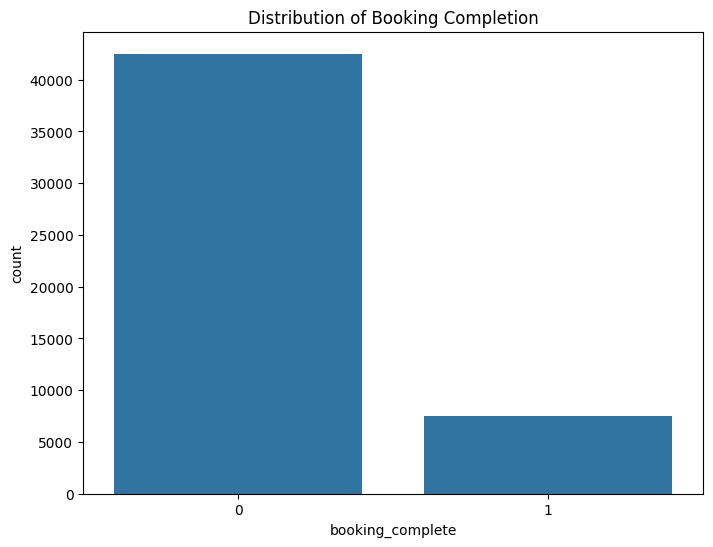

In [24]:
# Visualize the target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='booking_complete', data=df)
plt.title('Distribution of Booking Completion')
plt.savefig('booking_distribution.png')
plt.show()

In [25]:
# Identify categorical and numerical features
cat_features = df.select_dtypes(include=['object']).columns.tolist()
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'booking_complete' in num_features:
    num_features.remove('booking_complete')  # Remove target variable

print(f"\nCategorical features: {cat_features}")
print(f"Numerical features: {num_features}")


Categorical features: ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
Numerical features: ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']


### Categorical

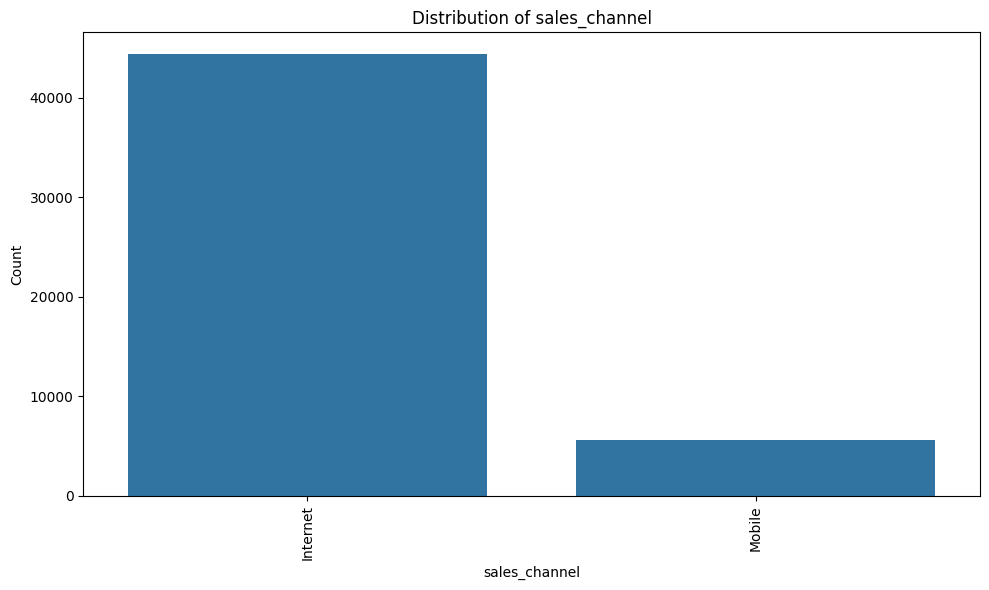


Distribution of sales_channel:
sales_channel
Internet    44382
Mobile       5618
Name: count, dtype: int64


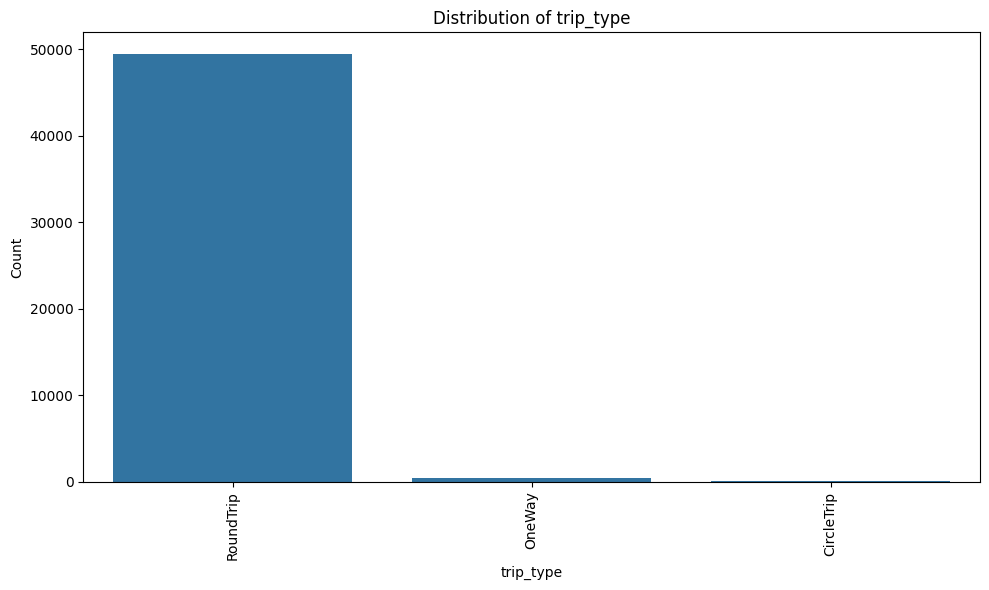


Distribution of trip_type:
trip_type
RoundTrip     49497
OneWay          387
CircleTrip      116
Name: count, dtype: int64


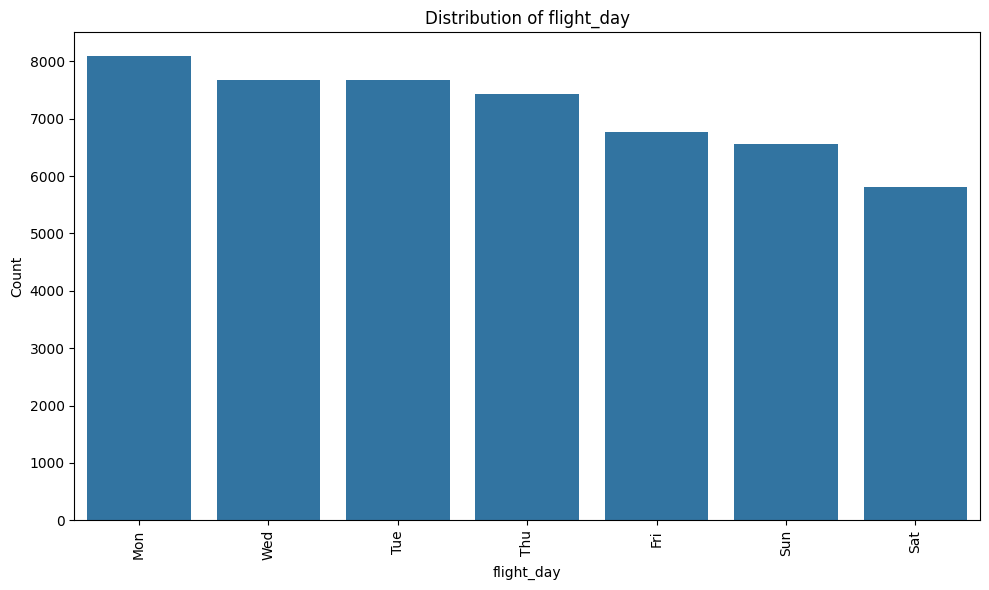


Distribution of flight_day:
flight_day
Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: count, dtype: int64


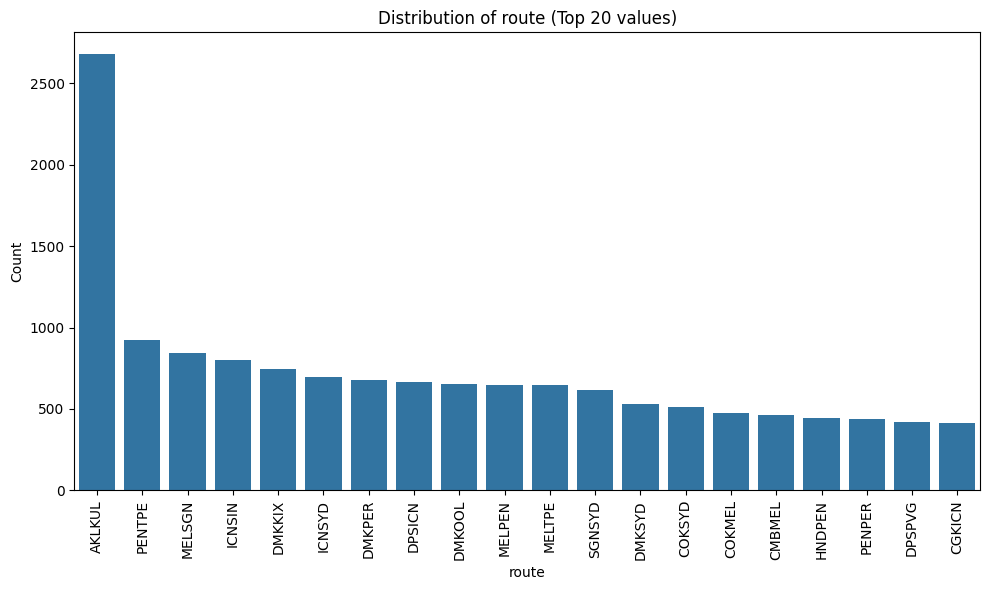


Distribution of route:
route
AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64


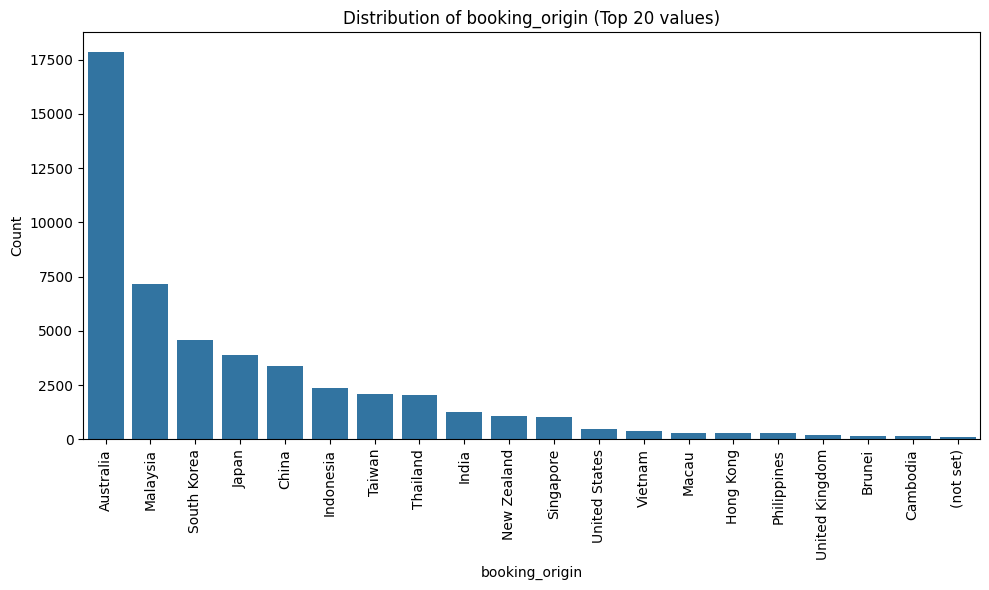


Distribution of booking_origin:
booking_origin
Australia               17872
Malaysia                 7174
South Korea              4559
Japan                    3885
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64


In [26]:
# Univariate analysis for categorical features
for feature in cat_features:
    plt.figure(figsize=(10, 6))
    value_counts = df[feature].value_counts().sort_values(ascending=False)
    
    # If there are too many categories, only show top 20
    if len(value_counts) > 20:
        plt.title(f'Distribution of {feature} (Top 20 values)')
        value_counts = value_counts.head(20)
    else:
        plt.title(f'Distribution of {feature}')
    
    # Create bar chart
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.xticks(rotation=90)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(f'{feature}_distribution.png')
    plt.show()
    
    print(f"\nDistribution of {feature}:")
    print(df[feature].value_counts())

### Numerical

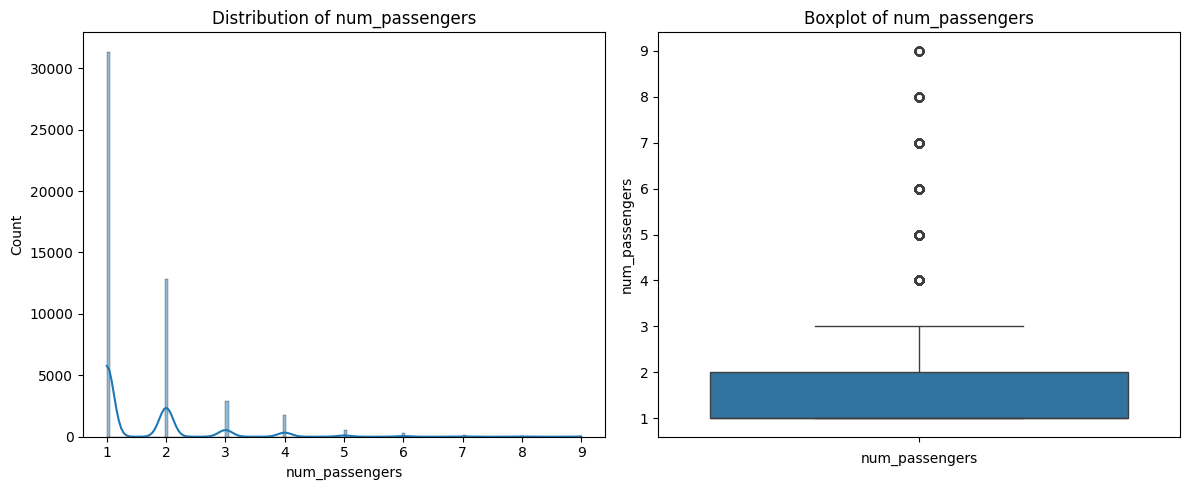


Statistics for num_passengers:
count    50000.000000
mean         1.591240
std          1.020165
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: num_passengers, dtype: float64


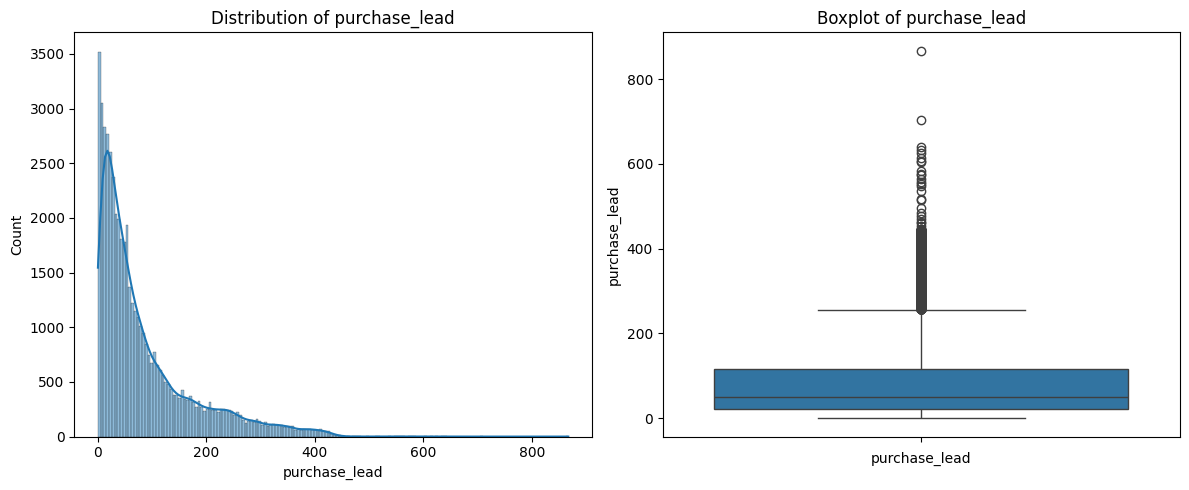


Statistics for purchase_lead:
count    50000.000000
mean        84.940480
std         90.451378
min          0.000000
25%         21.000000
50%         51.000000
75%        115.000000
max        867.000000
Name: purchase_lead, dtype: float64


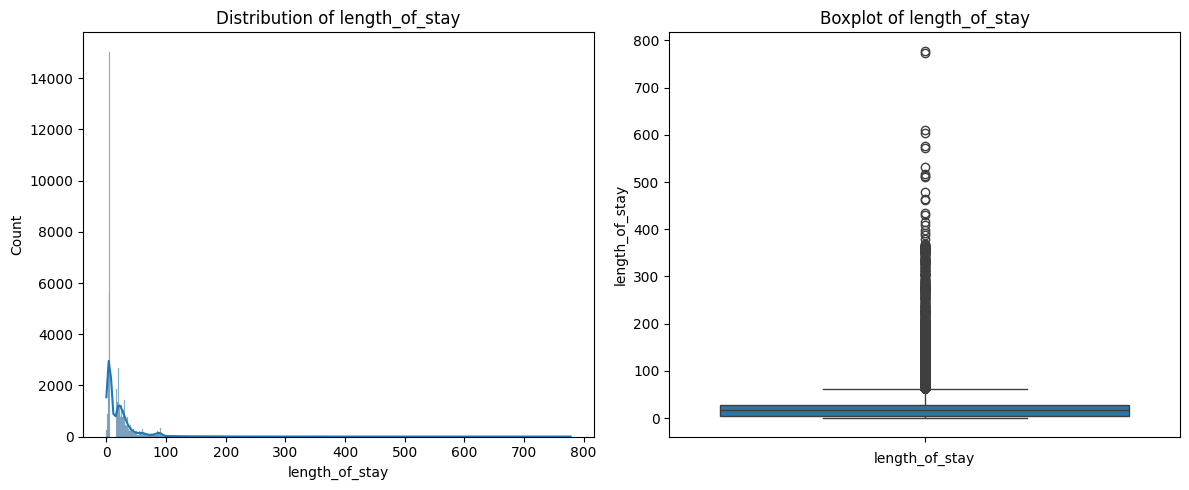


Statistics for length_of_stay:
count    50000.00000
mean        23.04456
std         33.88767
min          0.00000
25%          5.00000
50%         17.00000
75%         28.00000
max        778.00000
Name: length_of_stay, dtype: float64


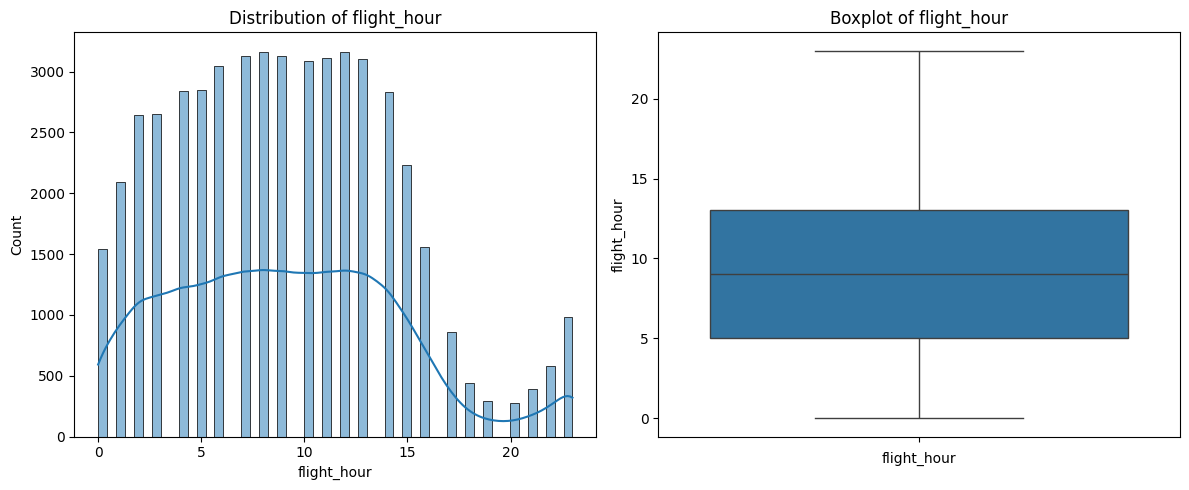


Statistics for flight_hour:
count    50000.00000
mean         9.06634
std          5.41266
min          0.00000
25%          5.00000
50%          9.00000
75%         13.00000
max         23.00000
Name: flight_hour, dtype: float64


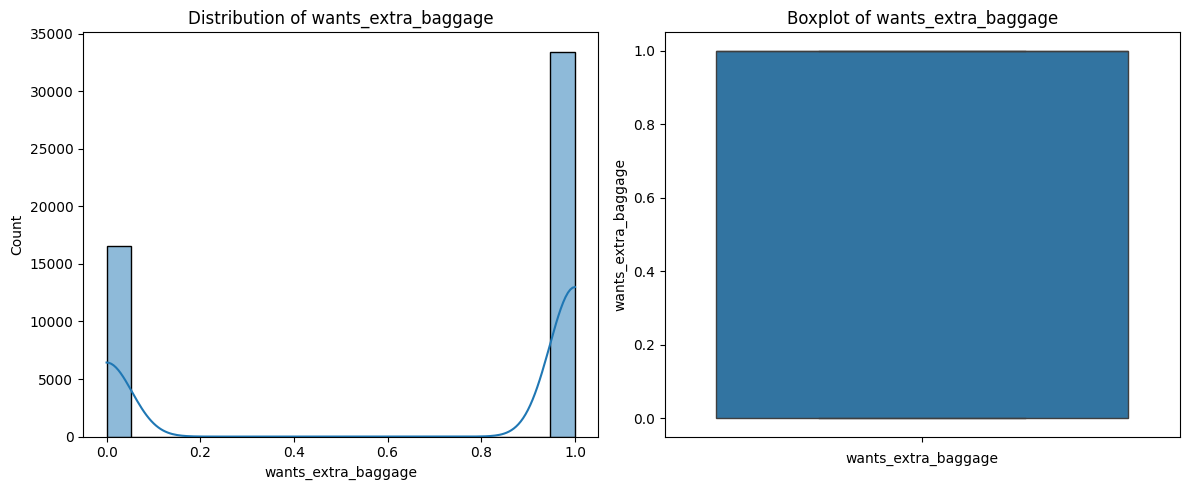


Statistics for wants_extra_baggage:
count    50000.000000
mean         0.668780
std          0.470657
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: wants_extra_baggage, dtype: float64


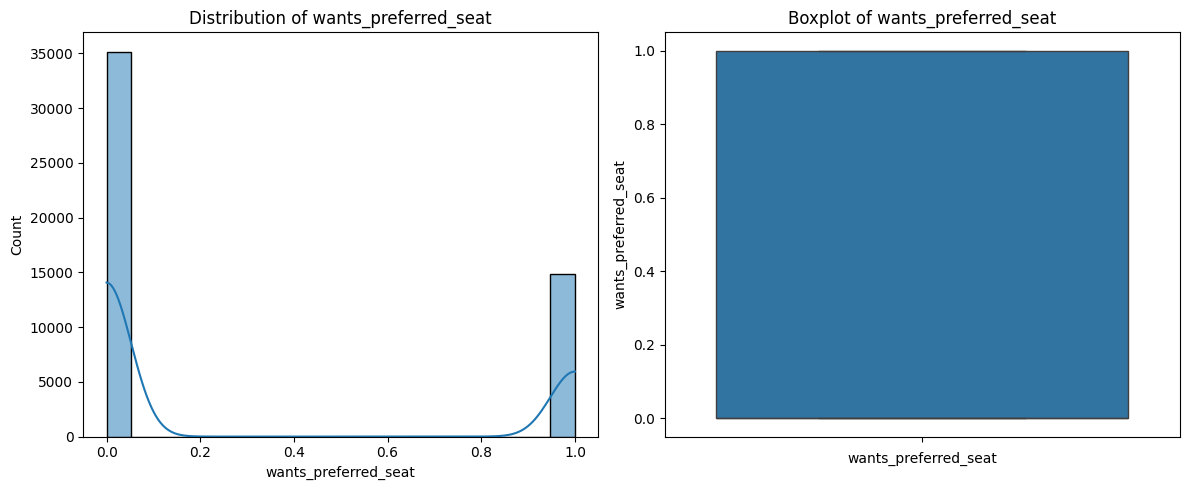


Statistics for wants_preferred_seat:
count    50000.000000
mean         0.296960
std          0.456923
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: wants_preferred_seat, dtype: float64


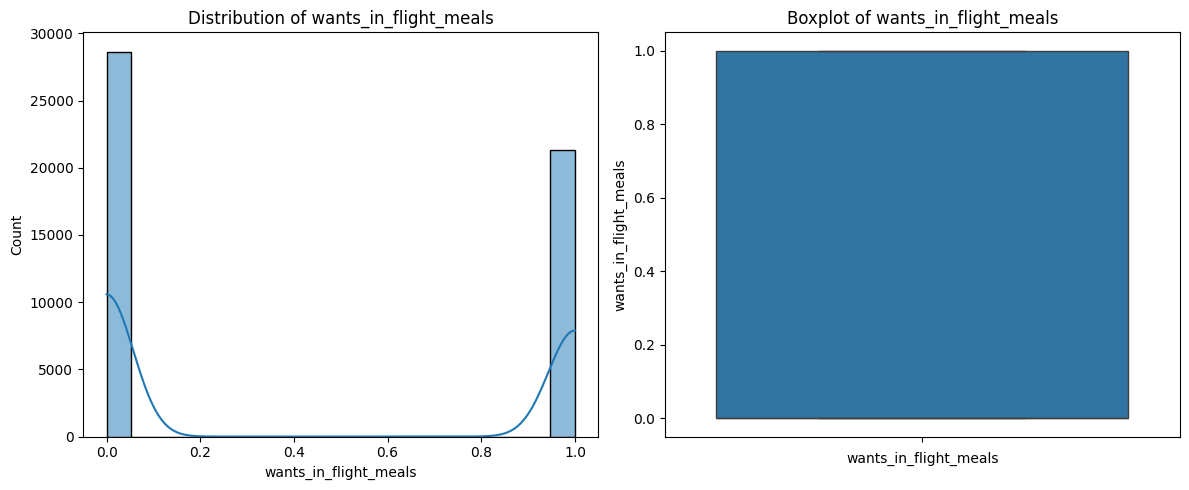


Statistics for wants_in_flight_meals:
count    50000.000000
mean         0.427140
std          0.494668
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: wants_in_flight_meals, dtype: float64


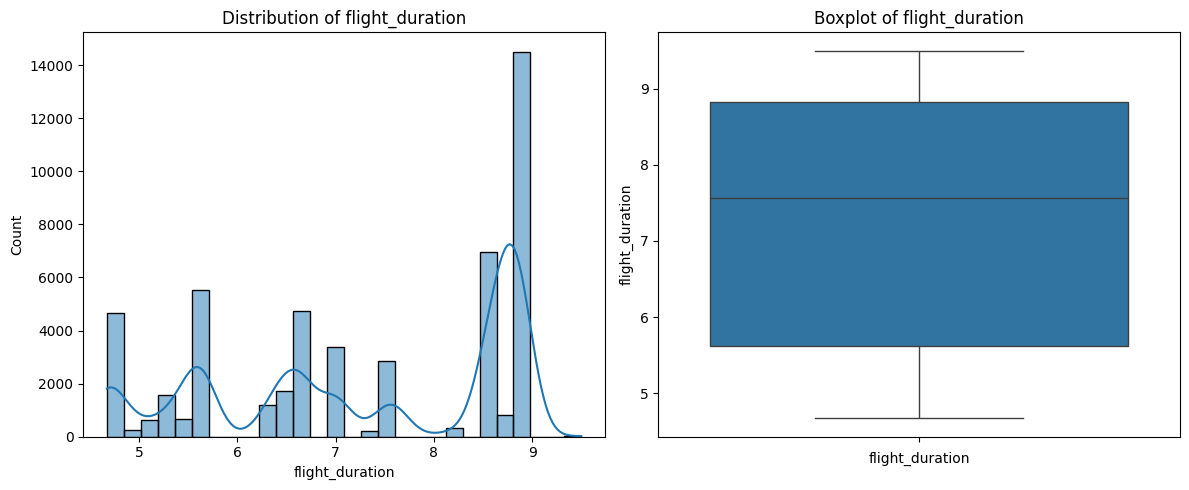


Statistics for flight_duration:
count    50000.000000
mean         7.277561
std          1.496863
min          4.670000
25%          5.620000
50%          7.570000
75%          8.830000
max          9.500000
Name: flight_duration, dtype: float64


In [27]:
# Univariate analysis for numerical features
for feature in num_features:
    plt.figure(figsize=(12, 5))
    
    # Create a subplot with 2 charts side by side
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nStatistics for {feature}:")
    print(df[feature].describe())

## Multivariate Analysis

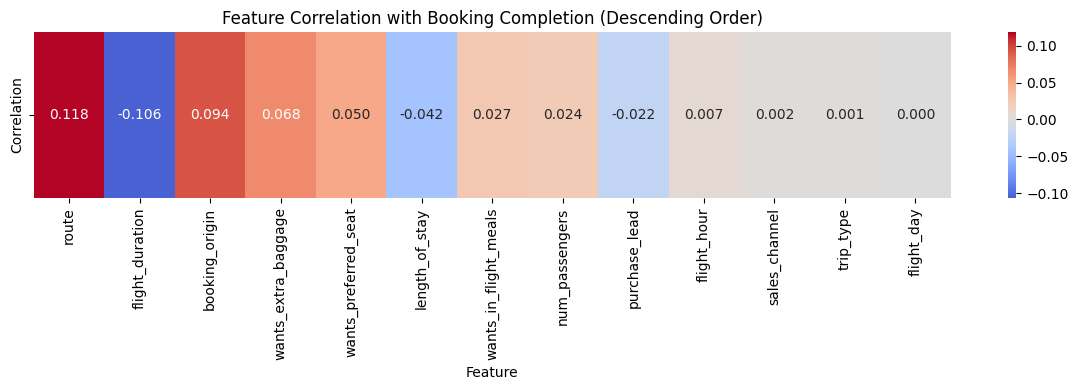

Feature correlations with booking_complete (sorted by value):
route: 0.1181
booking_origin: 0.0936
wants_extra_baggage: 0.0681
wants_preferred_seat: 0.0501
wants_in_flight_meals: 0.0265
num_passengers: 0.0241
flight_hour: 0.0071
sales_channel: 0.0017
trip_type: 0.0008
flight_day: 0.0003
purchase_lead: -0.0221
length_of_stay: -0.0424
flight_duration: -0.1063


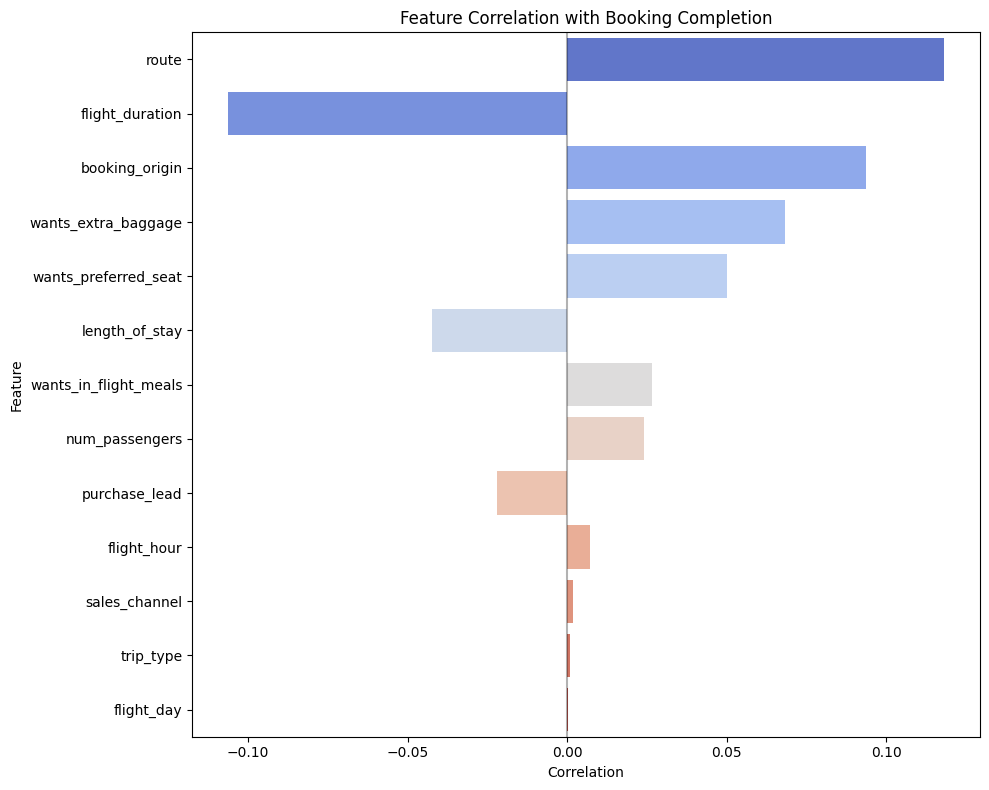

In [28]:
# Create a function to calculate correlation ratio (eta) for categorical variables
def correlation_ratio(categories, measurements):
    categories = pd.Series(categories)
    measurements = pd.Series(measurements)
    cat_means = measurements.groupby(categories).mean()
    overall_mean = measurements.mean()
    between_group_variability = sum([(cat_means[category] - overall_mean)**2 * sum(categories == category) 
                                    for category in categories.unique()])
    total_variability = sum((measurements - overall_mean)**2)
    if total_variability == 0:
        return 0
    return between_group_variability / total_variability

# Calculate correlations for numerical features
num_correlations = {}
for feature in num_features:
    corr = df[feature].corr(df['booking_complete'])
    num_correlations[feature] = corr

# Calculate correlation ratio for categorical features
cat_correlations = {}
for feature in cat_features:
    corr_ratio = correlation_ratio(df[feature], df['booking_complete'])
    cat_correlations[feature] = corr_ratio

# Combine all correlations
all_correlations = {**num_correlations, **cat_correlations}

# Sort correlations by absolute value
sorted_correlations = {k: v for k, v in sorted(all_correlations.items(), 
                                              key=lambda item: abs(item[1]), 
                                              reverse=True)}

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': list(sorted_correlations.keys()),
    'Correlation': list(sorted_correlations.values())
})

# Plot sorted heatmap in a single line
plt.figure(figsize=(12, 4))
sns.heatmap(
    feature_importance_df.set_index('Feature')['Correlation'].to_frame().T,
    annot=True, cmap='coolwarm', fmt='.3f', center=0
)
plt.title('Feature Correlation with Booking Completion (Descending Order)')
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png')
plt.show()

# Also create a horizontal bar plot for better visualization
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Correlation',
    y='Feature',
    data=feature_importance_df,
    palette='coolwarm',
    orient='h'
)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.title('Feature Correlation with Booking Completion')
plt.tight_layout()
plt.savefig('feature_correlation_barplot.png')

# Sort correlations by value (positive first, then negative)
sorted_correlations = {k: v for k, v in sorted(all_correlations.items(), key=lambda item: item[1], reverse=True)}

print("Feature correlations with booking_complete (sorted by value):")
for feature, corr in sorted_correlations.items():
    print(f"{feature}: {corr:.4f}")

# Data Preprocessing

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Prepare data for modeling
print("\nPreparing data for modeling...")
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Preparing data for modeling...
Training set size: (40000, 13)
Testing set size: (10000, 13)


In [ ]:
# Identify categorical and numerical features
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical features: {cat_features}")
print(f"Numerical features: {num_features}")

# Process categorical features using Label Encoding
print("\nEncoding categorical features using Label Encoding...")
label_encoders = {}

# Create copies to avoid modifying the original dataframes
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Apply label encoding to each categorical column
for col in cat_features:
    le = LabelEncoder()
    # Fit on training data only to prevent data leakage
    le.fit(X_train[col])
    
    # Transform both training and test data
    X_train_encoded[col] = le.transform(X_train[col])
    
    # Handle potential unknown categories in test set
    X_test_encoded[col] = X_test[col].map(dict(zip(le.classes_, le.transform(le.classes_))))
    X_test_encoded[col] = X_test_encoded[col].fillna(-1)  # Mark unknown categories with -1
    
    # Store the encoder for future reference
    label_encoders[col] = le
    
    # Print mapping for reference
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"Encoding mapping for {col}: {mapping}")

# Apply standard scaling to numerical features
print("\nScaling numerical features...")
scaler = StandardScaler()
X_train_encoded[num_features] = scaler.fit_transform(X_train_encoded[num_features])
X_test_encoded[num_features] = scaler.transform(X_test_encoded[num_features])

# Verify the encoded data
print("\nEncoded training data sample:")
print(X_train_encoded.head())

# Check for any remaining non-numeric values
non_numeric_check = X_train_encoded.select_dtypes(include=['object']).columns.tolist()
if len(non_numeric_check) > 0:
    print(f"\nWarning: These columns still contain non-numeric values: {non_numeric_check}")
else:
    print("\nSuccess: All features are now numeric")

# Final dataset shapes
print(f"\nFinal encoded training set shape: {X_train_encoded.shape}")
print(f"Final encoded testing set shape: {X_test_encoded.shape}")


Categorical features: ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
Numerical features: ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration']

Encoding categorical features using Label Encoding...
Encoding mapping for sales_channel: {'Internet': 0, 'Mobile': 1}
Encoding mapping for trip_type: {'CircleTrip': 0, 'OneWay': 1, 'RoundTrip': 2}
Encoding mapping for flight_day: {'Fri': 0, 'Mon': 1, 'Sat': 2, 'Sun': 3, 'Thu': 4, 'Tue': 5, 'Wed': 6}
Encoding mapping for route: {'AKLDEL': 0, 'AKLHGH': 1, 'AKLHND': 2, 'AKLICN': 3, 'AKLKIX': 4, 'AKLKTM': 5, 'AKLKUL': 6, 'AKLMRU': 7, 'AKLPEK': 8, 'AKLPVG': 9, 'AKLTPE': 10, 'AORICN': 11, 'AORKIX': 12, 'AORKTM': 13, 'AORMEL': 14, 'AORPER': 15, 'AORPUS': 16, 'BBIOOL': 17, 'BBIPER': 18, 'BBISYD': 19, 'BDOCTS': 20, 'BDOCTU': 21, 'BDOHGH': 22, 'BDOICN': 23, 'BDOIKA': 24, 'BDOKIX': 25, 'BDOMEL': 26, 'BDOOOL': 27, 'BDOPEK': 2

# Modelling: Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


Training Random Forest model...
Making predictions on test set...

--- Model Performance Metrics ---
Accuracy: 0.8539
Precision: 0.5636
Recall: 0.1036
F1 Score: 0.1750


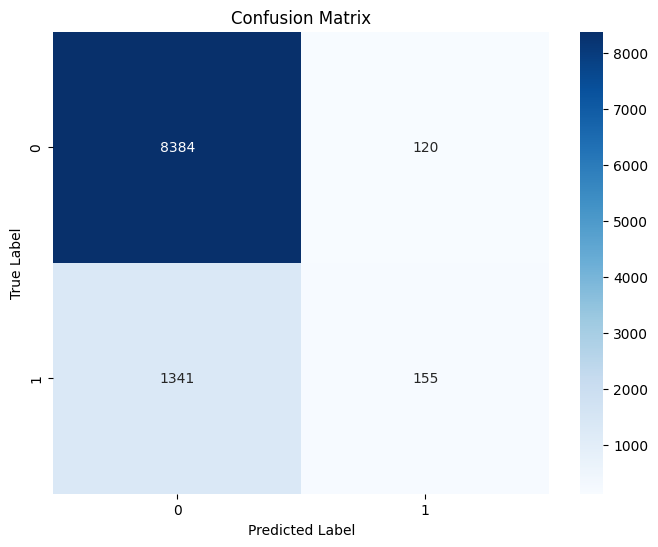


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.56      0.10      0.18      1496

    accuracy                           0.85     10000
   macro avg       0.71      0.54      0.55     10000
weighted avg       0.82      0.85      0.81     10000


Performing 5-fold cross-validation...
Cross-validation scores: [0.852625 0.852625 0.851875 0.85275  0.8525  ]
Mean CV accuracy: 0.8525
Standard deviation: 0.0003

--- Feature Importance Analysis ---


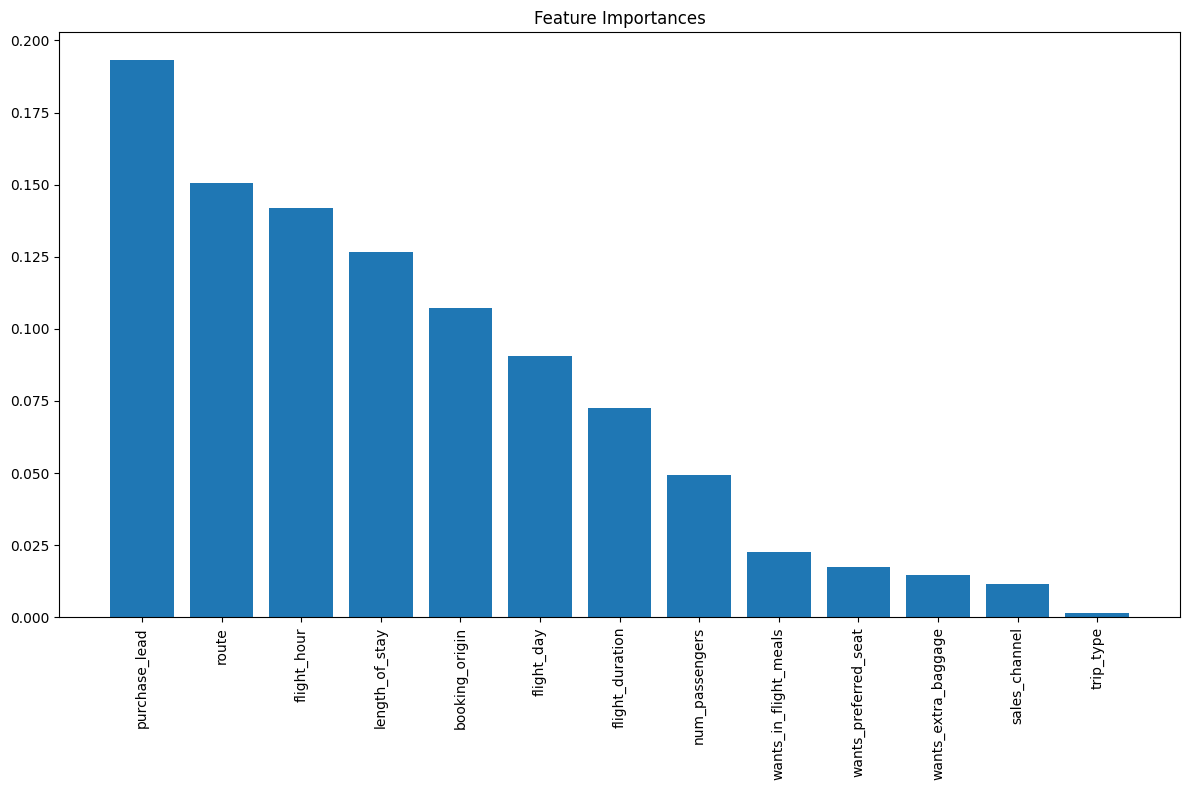

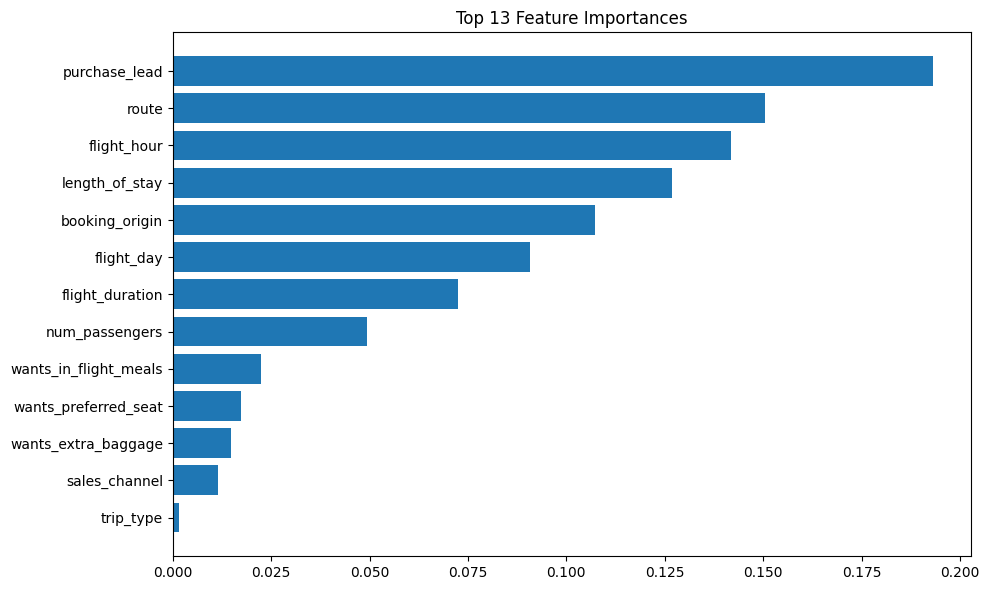

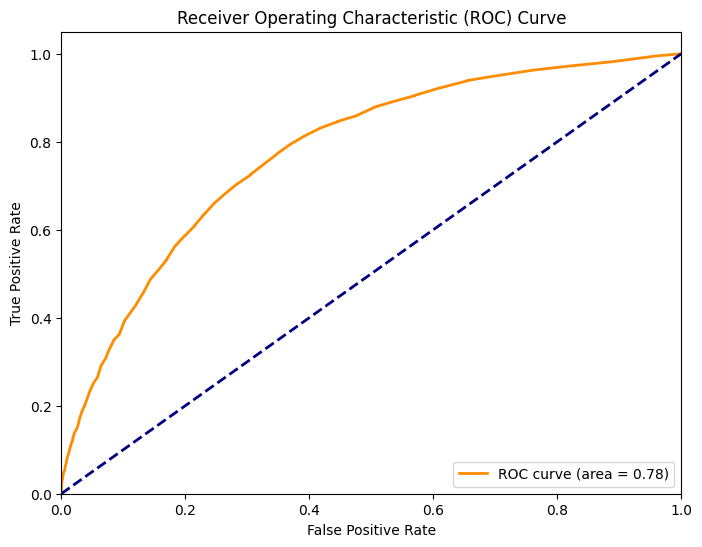


ROC AUC Score: 0.7765

Random Forest model training and evaluation complete!


In [ ]:
# Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

y_pred = rf_model.predict(X_test_encoded)

# Calculate performance metrics
print("\n--- Model Performance Metrics ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Perform cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(rf_model, X_train_encoded, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Feature importance
print("\n--- Feature Importance Analysis ---")
# Extract and sort feature importances
feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), [X_train_encoded.columns[i] for i in sorted_idx], rotation=90)
plt.tight_layout()
plt.show()

# Plot top N features
top_n = min(15, len(sorted_idx))  # Adjust based on number of features
plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Feature Importances")
plt.barh(range(top_n), feature_importances[sorted_idx][:top_n], align='center')
plt.yticks(range(top_n), [X_train_encoded.columns[i] for i in sorted_idx][:top_n])
plt.gca().invert_yaxis()  # Invert to have highest importance at the top
plt.tight_layout()
plt.show()

# ROC curve and AUC
y_prob = rf_model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")